# Impact Chart Demo

In [1]:
import itertools

import censusdis.data as ced
from censusdis.datasets import ACS5
import censusdis.states as states

import pandas as pd

import xgboost

from scipy import stats
from sklearn.model_selection import RandomizedSearchCV

from impactchart.model import XGBoostImpactModel

import impactchartdemo.data

from matplotlib.ticker import FuncFormatter, PercentFormatter

## 1. Feature Engineering

### Download the U.S. Census Data

We will download data for all of the block groups in a single Core Based Statistical Area (CBSA).
A CBSA is what is commonly known as a metro area. The U.S. Census API also called it a 
`metropolitan_statistical_area_micropolitan_statistical_area`.

In [2]:
# What CBSA
CBSA = '40060'  # Richmond, VA

### Features, Target, and Weights

In [3]:
X, y, w, feature_names = impactchartdemo.data.home_value_demongraphics_data(CBSA)

In [4]:
X.head()

,frac_B03002_003E,frac_B03002_004E,frac_B03002_005E,frac_B03002_006E,frac_B03002_007E,frac_B03002_008E,frac_B03002_010E,frac_B03002_011E,frac_B03002_012E,B19013_001E
0,0.827233,0.070278,0.0,0.000000,0.0,0.0,0.0,0.000000,0.102489,55625.0
1,0.739857,0.214797,0.0,0.000000,0.0,0.0,0.0,0.038186,0.007160,54052.0
3,0.662211,0.307412,0.0,0.000000,0.0,0.0,0.0,0.030377,0.000000,63878.0
4,0.797127,0.202873,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,68987.0
5,0.841046,0.158283,0.0,0.000671,0.0,0.0,0.0,0.000000,0.000000,44557.0


In [5]:
pd.DataFrame(y).head()

,B25077_001E
0,243200.0
1,188100.0
3,197100.0
4,184000.0
5,223200.0


In [6]:
pd.DataFrame(w).head()

,B25003_002E
0,497
1,365
3,516
4,278
5,504


## 2. Optimize the Hyperparameters for an XGBoost Model

### Construct a Randomized Grid Search

In [7]:
reg_xgb = xgboost.XGBRegressor()

In [8]:
param_dist = {
    "n_estimators": stats.randint(10, 100),
    "learning_rate": stats.uniform(0.01, 0.07),
    "subsample": stats.uniform(0.3, 0.7),
    "max_depth": stats.randint(2, 6),
    "min_child_weight": stats.randint(1, 4),
}

reg = RandomizedSearchCV(
    reg_xgb,
    param_distributions=param_dist,
    n_iter=200,
    error_score=0,
    n_jobs=-1,
    verbose=1,
    scoring='neg_mean_absolute_percentage_error', # See 'https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter'
    random_state=123999,
)

### Optimize the Hyperparameters

In [9]:
reg.fit(X, y, sample_weight=w)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(error_score=0,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learn...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x2a6098710>,
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x2a6099d10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x2a59666d0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x2a609b0d0>},
                   random_state=123999,
                   scoring='neg_mean_absolute_percentage_error', verbose=1)

In [10]:
params = reg.best_params_

params

{'learning_rate': 0.05720241314632869,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 70,
 'subsample': 0.44969452321164133}

In [11]:
# This is the best NMAPE score.
reg.best_score_

-0.2962866461062223

In [12]:
# This is the default score, which is r^2.
reg.best_estimator_.score(X, y, sample_weight=w)

0.7286402815450499

## 3. Generate the Impact Charts

In [13]:
impact_model = XGBoostImpactModel(
    random_state=1779, estimator_kwargs=params
)

In [14]:
impact_model.fit(X, y, sample_weight=w)

In [15]:
dollar_formatter = FuncFormatter(
    lambda d, pos: f"\\${d:,.0f}" if d >= 0 else f"(\\${-d:,.0f})"
)

percent_formatter = PercentFormatter(1.0, decimals=0)

CPU times: user 1min 26s, sys: 14.9 s, total: 1min 40s
Wall time: 1min 12s


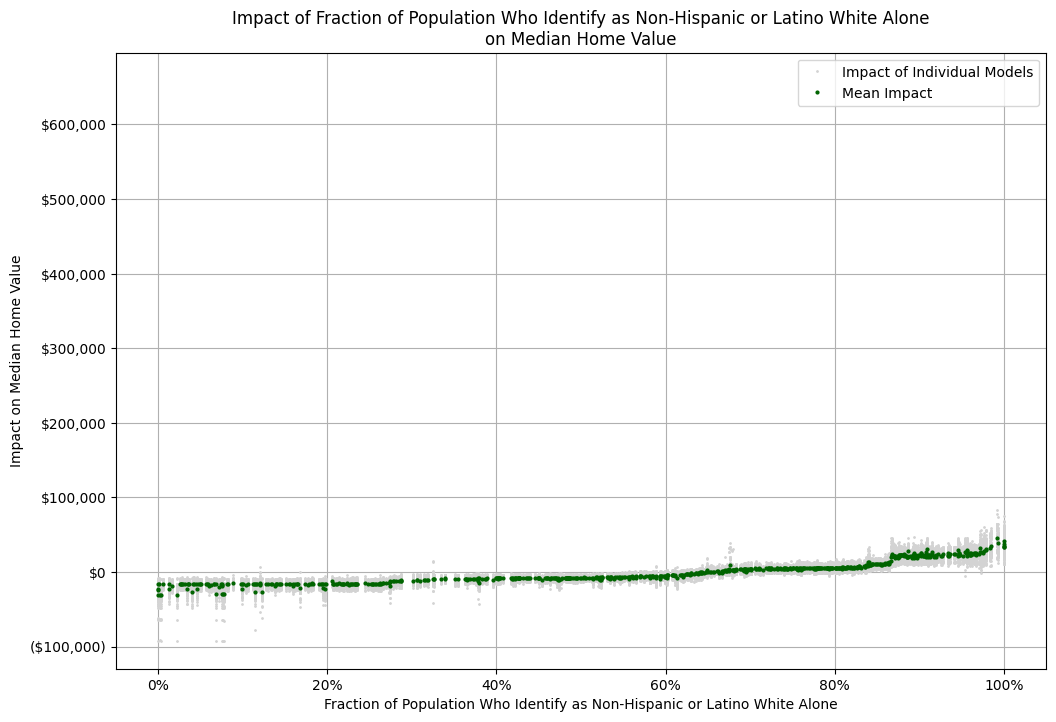

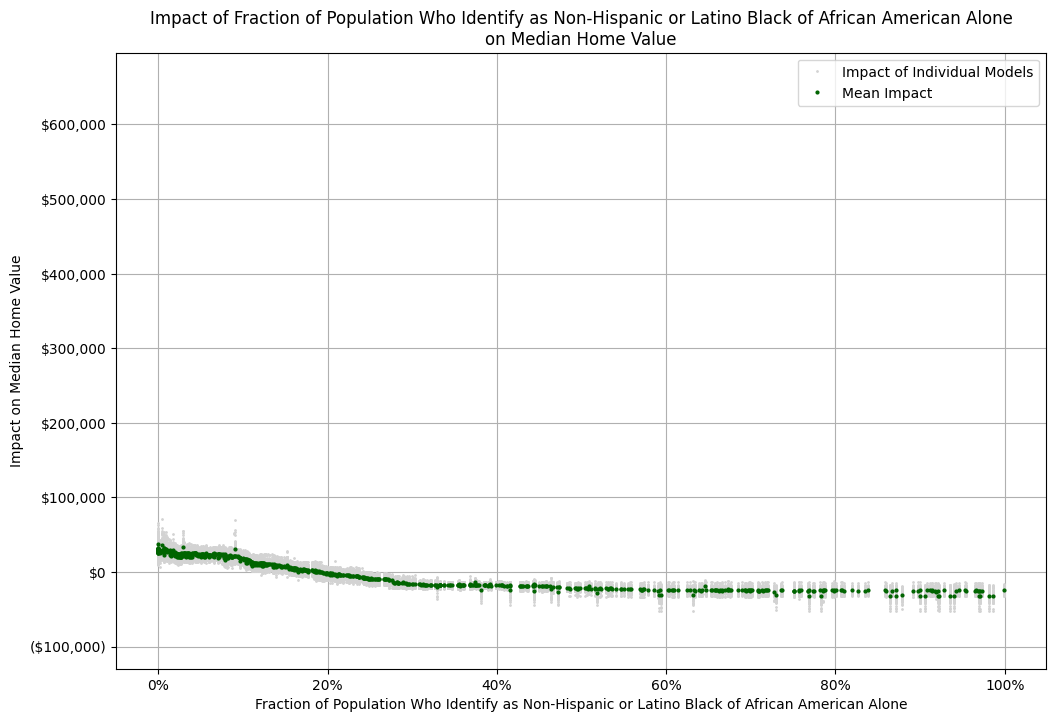

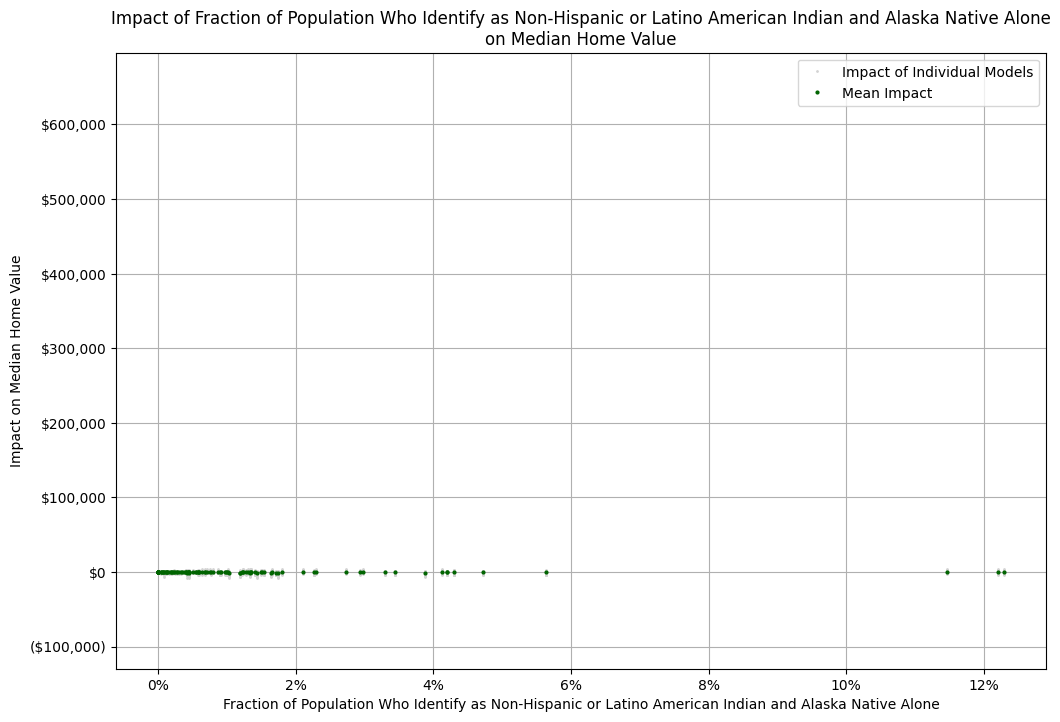

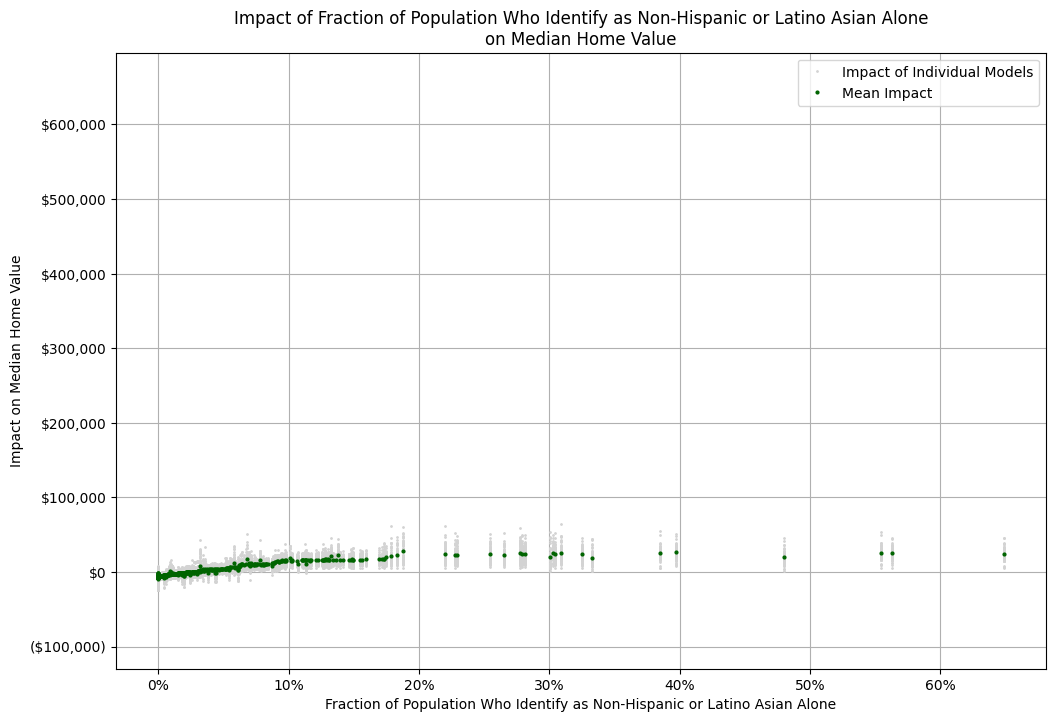

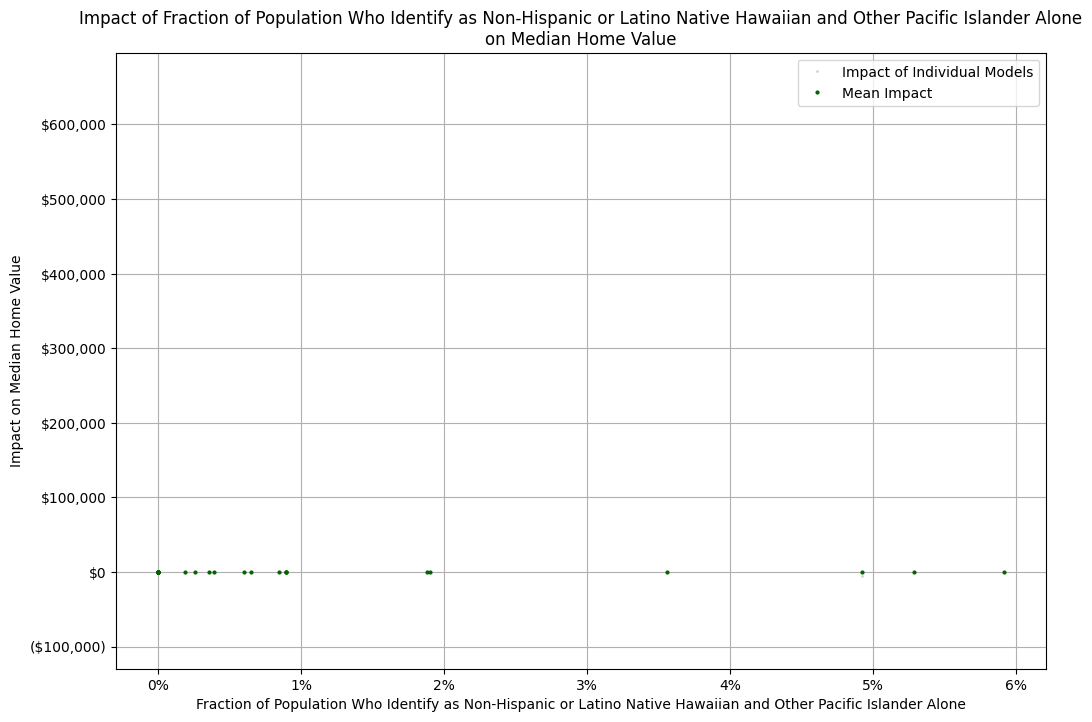

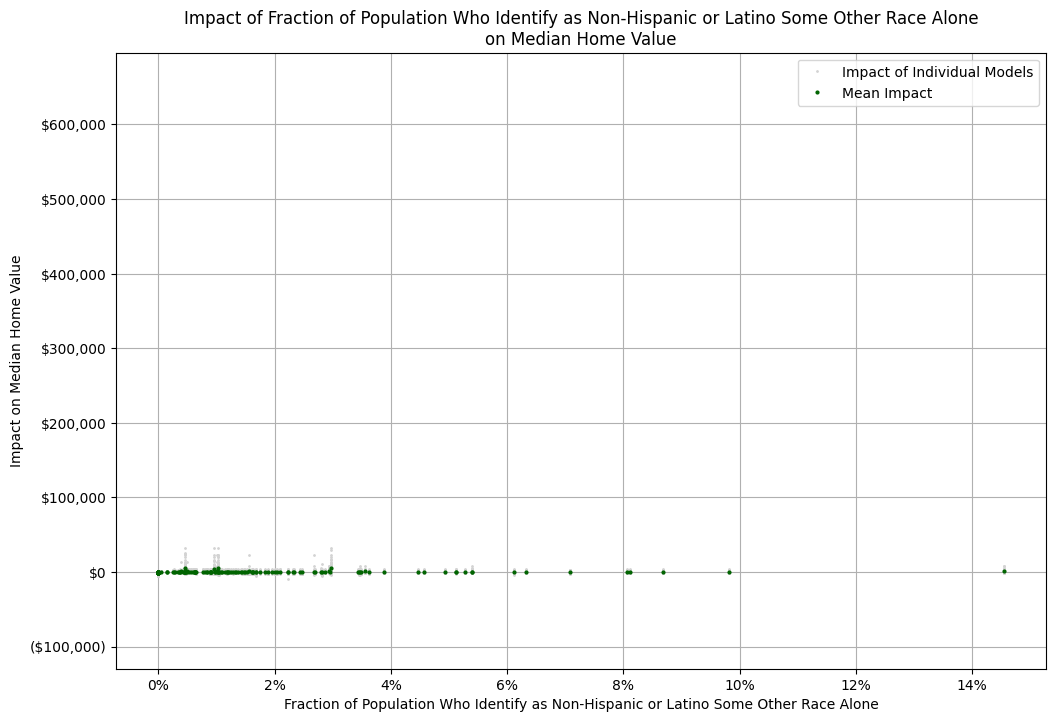

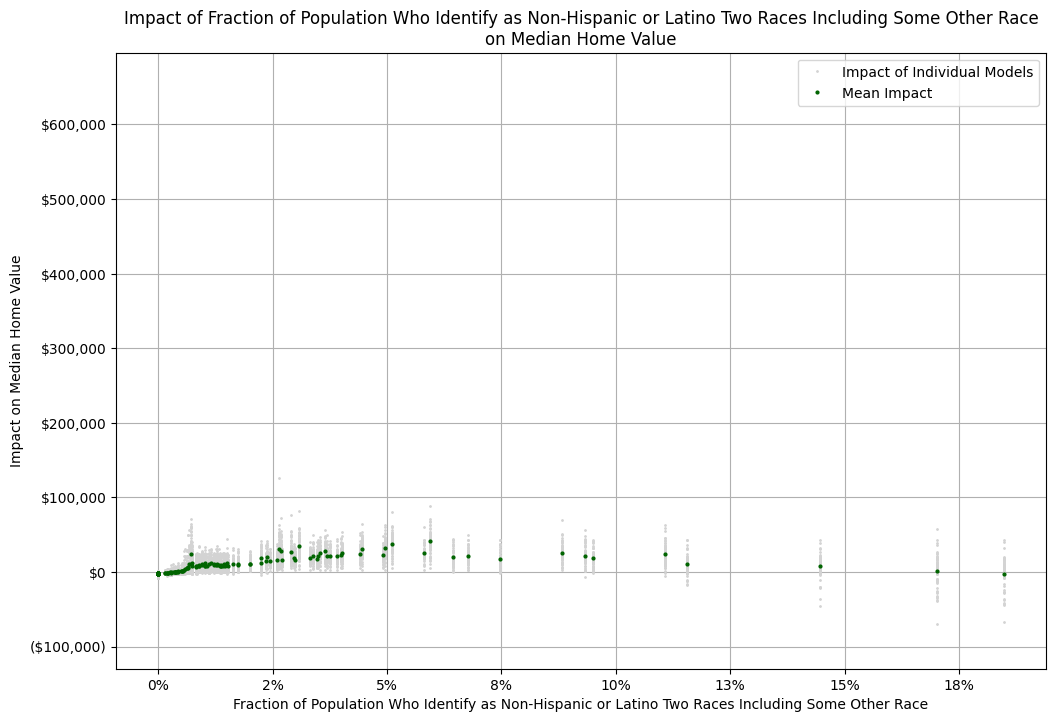

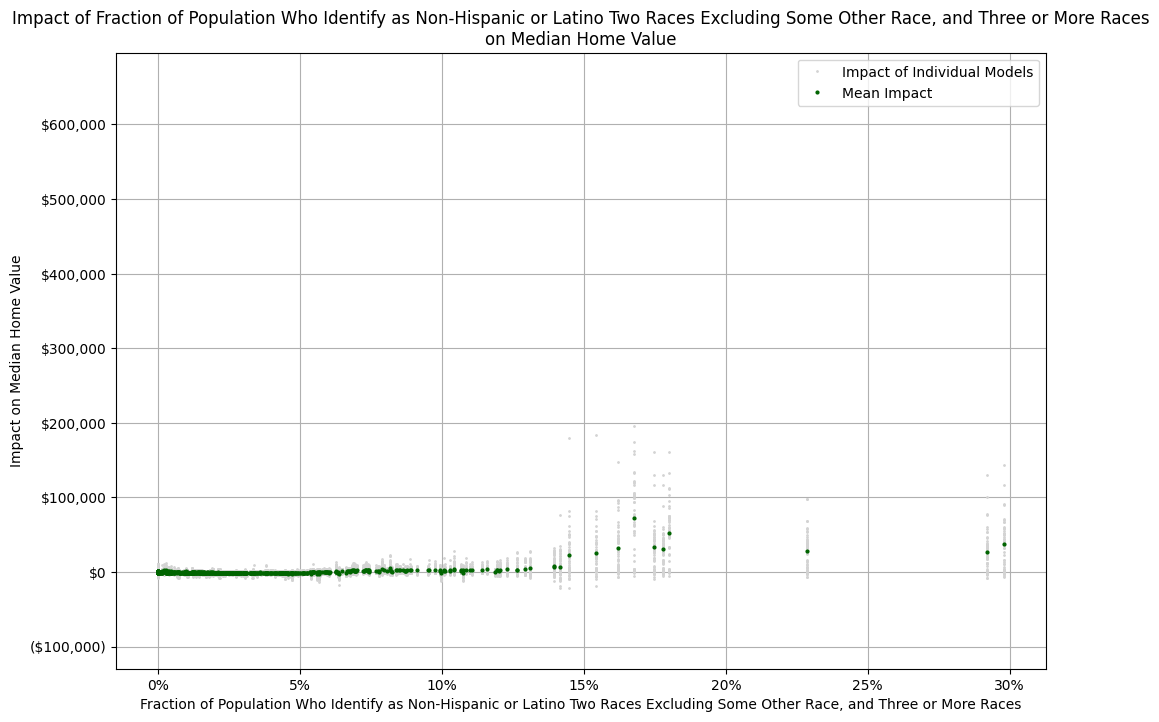

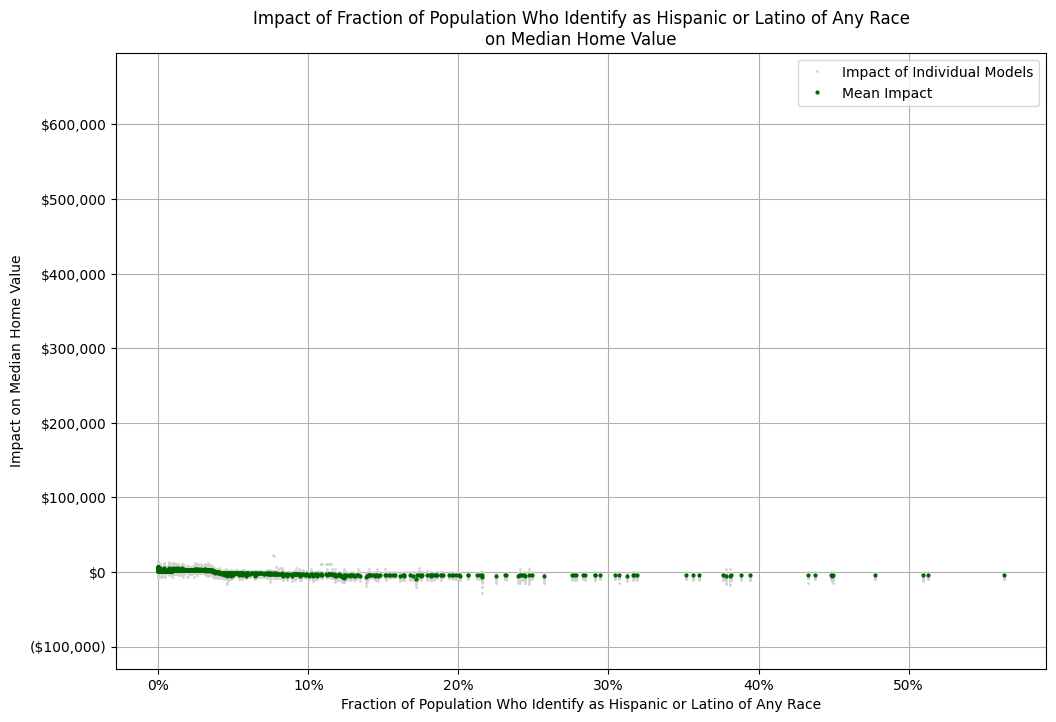

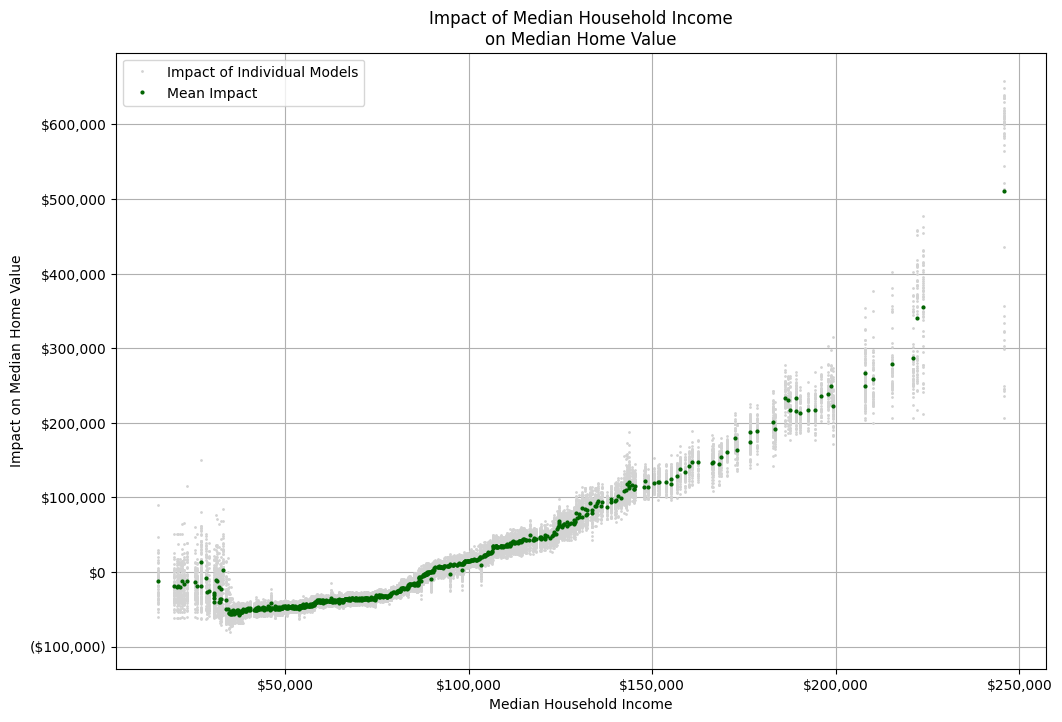

In [16]:
%%time

# This is where the heavy lifting of generating the impact charts happens:

impact_charts = impact_model.impact_charts(
    X,
    X.columns,
    subplots_kwargs=dict(
        figsize=(12, 8),
    ),
    feature_names=feature_names,
    y_name=impactchartdemo.data.TARGET_NAME,
)

# This is just some post-processing to format the axes nicely on a per-feature basis:

for fig, ax in impact_charts.values():
    ax.yaxis.set_major_formatter(dollar_formatter)

for feature, (fig, ax) in impact_charts.items():
    if feature == impactchartdemo.data.VARIABLE_MEDIAN_HOUSEHOLD_INCOME:
        ax.xaxis.set_major_formatter(dollar_formatter)
    else:
        ax.xaxis.set_major_formatter(percent_formatter)